In [1]:
!pip install transformers
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext.data as data
import pandas as pd
import torchtext
import string
import re
import spacy
import csv
import random
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertPreTrainedModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

DATA = {
    'train': 'drive/My Drive/NLP/toxic_comments_classification/toxic_comment/train.csv',
    'preprocess':'drive/My Drive/NLP/toxic_comments_classification/toxic_comment/preprocess.csv',
    'test': 'drive/My Drive/NLP/toxic_comments_classification/toxic_comment/test.csv',
    'preprocess_test':'drive/My Drive/NLP/toxic_comments_classification/toxic_comment/preprocess_test.csv',
    'test_labels': 'drive/My Drive/NLP/toxic_comments_classification/toxic_comment/test_labels.csv'
}

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

     |████████████████████████████████| 1.0MB 4.8MB/s 
     |████████████████████████████████| 890kB 27.8MB/s 
     |████████████████████████████████| 3.0MB 19.5MB/s 
     |████████████████████████████████| 1.1MB 56.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=21e98dd07406256a905fc26bf17e1b2464794669d10712d31419d229d11f356d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
cuda:0


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
SEED = 40
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
train_data = pd.read_csv(DATA['train'])
print(train_data.head())

                 id  ... identity_hate
0  0000997932d777bf  ...             0
1  000103f0d9cfb60f  ...             0
2  000113f07ec002fd  ...             0
3  0001b41b1c6bb37e  ...             0
4  0001d958c54c6e35  ...             0

[5 rows x 8 columns]


In [5]:
punctuations = string.punctuation
token = spacy.load('en')

stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words.update(['wikipedia','article','articles','im','page'])
lemmatizer = WordNetLemmatizer()
#spacy = torchtext.data.utils.get_tokenizer('spacy')

def preprocessing(text):
  
    def tokenizer(text):
        text = str.split(text)
        return text
    
    def remove_punctuations(sentence):
        result = "".join([w if w not in punctuations and not w.isdigit() else " " for w in sentence])
        return result
    
    def word_lemmatizer(sentence):
        result = lemmatizer.lemmatize(sentence)
        return result
    
    def word_lowercase(sentence):
        return sentence.lower()
    
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        html = re.compile(r'<.*?>')
        text = html.sub(r'',text)
        text = url.sub(r'',str(text))
        return text
  
    def remove_newline(text):
        return text.rstrip("\n")
    
    def clean(sentence):
        result = []
        sentence = remove_newline(sentence)
        sentence = remove_URL(sentence)
        sentence = word_lowercase(sentence)
        sentence = word_lemmatizer(sentence)
        sentence = remove_punctuations(sentence)
        sentence = tokenizer(sentence)

        result = " ".join(sentence)
        return result
    
    #result = generate_bigrams(result)  
    text = clean(text)
    if text == "":
        text = "None"
    return text

In [6]:
# with open(DATA['train'], 'r', encoding = 'utf8') as read_csv, open(DATA['preprocess'], 'w', encoding = 'utf8') as write_csv:
#     reader = csv.reader(read_csv)
#     writer = csv.writer(write_csv)
#     next(reader, None)
#     for row in tqdm(reader):
#         row[1] = preprocessing(row[1])
#         writer.writerow(row)

# with open(DATA['test'], 'r', encoding = 'utf8') as read_csv, open(DATA['preprocess_test'], 'w', encoding = 'utf8') as write_csv:
#     reader = csv.reader(read_csv)
#     writer = csv.writer(write_csv)
#     next(reader, None)
#     for row in tqdm(reader):
#         row[1] = preprocessing(row[1])
#         writer.writerow(row)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased'] 
print(f"Maximum length that a single input can have using this model: {max_input_length} words")


Maximum length that a single input can have using this model: 512 words


In [8]:
def tokenize(text):
    tokens = str.split(text)
    tokens = tokens[:max_input_length - 2]

    return tokens

In [9]:
TEXT = data.Field(batch_first = True,
                  lower = True,
                  use_vocab = False,
                  tokenize = tokenize,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.eos_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id,
                  stop_words = stop_words)
LABEL = data.LabelField(dtype = torch.float)
TEST_LABEL = data.Field(sequential = False)

dataFields = [('id', None),
              ('comment_text', TEXT),
              ('toxic', LABEL),
              ('severe_toxic', LABEL),
              ('obscene', LABEL),
              ('threat', LABEL),
              ('insult', LABEL),
              ('identity_hate', LABEL)]

testFields = [('id', TEST_LABEL),
              ('comment_text', TEXT)]

dataset = data.TabularDataset(path = DATA['preprocess'],
                              format = 'csv',
                              fields = dataFields,
                              skip_header = True)
test_dataset = data.TabularDataset(path = DATA['preprocess_test'],
                                   format = 'csv',
                                   skip_header = True,
                                   fields = testFields)

In [10]:
train, val = dataset.split(random_state = random.seed(SEED))

In [11]:
LABEL.build_vocab(train)
TEST_LABEL.build_vocab(test_dataset)
print(f"Unique words in training set: {len(tokenizer.vocab)}")
print(f"Unique labels in training set: {len(LABEL.vocab)}")
print(f"Unique labels in training set: {len(TEST_LABEL.vocab)}")

Unique words in training set: 30522
Unique labels in training set: 2
Unique labels in training set: 153164


In [12]:
print(TEST_LABEL.vocab.freqs.most_common(5))
print(LABEL.vocab.freqs.most_common(5))

[('0000247867823ef7', 1), ('00013b17ad220c46', 1), ('00017563c3f7919a', 1), ('00017695ad8997eb', 1), ('0001ea8717f6de06', 1)]
[('0', 645650), ('1', 24544)]


In [13]:
train_loader, val_loader = data.BucketIterator.splits(datasets = (train, val), 
                                                      batch_sizes = (8, 8), 
                                                      sort_key = lambda x: len(x.comment_text),
                                                      device = device, 
                                                      sort_within_batch = True, 
                                                      repeat = False)

test_loader = data.BucketIterator(test_dataset,
                                  batch_size = 8,
                                  shuffle = False,
                                  device = device)

model = BertModel.from_pretrained('bert-base-uncased')


In [14]:
# Wrap to tuple with x and y, handling when update features
class BatchGenerator:
    def __init__(self, dl, x, y_fields):
        self.dl = dl
        self.y_fields = y_fields
        self.x = x

    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            #print('x: ',self. x)
            #print('y_fields: ', self.y_fields)
            x = getattr(batch, self.x)
            if self.y_fields is not None:
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_fields], dim = 1).float()
                #print('y_size: ', y.size())
            else:
                y = torch.zeros((1))
                #print('y_size when y_fields is None: ', y.size())
            yield (x,y)

train_loader = BatchGenerator(train_loader, "comment_text", ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
val_loader = BatchGenerator(val_loader, "comment_text", ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
test_loader = BatchGenerator(test_loader, "comment_text", None)

In [15]:
next(train_loader.__iter__())


(tensor([[  101,  7592,  2062,  6090,  2630,  6793,  2054,  2003,  1996,  2088,
           2746,  2000,  2559,  2830,  2000,  2115,  5857,  2006,  1996,  2117,
          19432,  2887,  2162,   100,   100,   100,  2064,  2022,  1997,  2307,
           2393,  2065,  2017,  5454,  2000,  2202,  1037,  2298,  2012,  2009,
            100,  1056,  1039,  1049,  1041],
         [  101,  4216,  4216,  2005,  2026,  3431,  4012,  2013,  2732,  5233,
            100,  2027,  2175,  1996,  2592,  2013,  2732,  5233,  4012,  1045,
           2052,  5587,  2009,  2021,  2732,  5233,   100,   100,  1056,  2507,
           2033,  2037,  4216,  2017,  2222, 12453,  1996,  4216,  2012,  2732,
           5233,   100,  1998,  2037,  4216],
         [  101,  4067,  2017,   100,  2005,  5128,  1996,  3277,  2012,  2192,
           2061,  4415,  5525,  2115, 15690,  2024,  3115,  2021,   100,  2097,
           4050,  2655,  2023,  2828,  1997,  7863,  3921,  2434,  2470,  2061,
           2004,  2000,  241

In [16]:
class SimpleBertClassifier(nn.Module):
    def __init__(self, bert, num_classes = 6):
        super(SimpleBertClassifier, self).__init__()
        self.bert = bert
        self.linear = nn.Linear(bert.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask = None, 
                token_type_ids = None, position_ids = None, 
                head_mask = None, labels = None):
        x = self.bert(input_ids, attention_mask = attention_mask,
                      token_type_ids = token_type_ids, position_ids = position_ids,
                      head_mask  = head_mask)
        output = x[1] # hidden size, pooled_output
        output = self.linear(output) # batch, num_classes
        outputs = torch.sigmoid(output)
        loss = 0
        #print('Outputs: ', outputs)
        #print('Labels: ', labels)
        criterion = nn.BCELoss().to(device)
        if labels is not None:
            loss = criterion(outputs, labels)
            #print('Loss: ', loss)
        
        return loss, outputs
        
""" GRU model """
class BertGRU(nn.Module):
    def __init__(self, bert, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout):
        super(BertGRU, self).__init__()
        self.bert = bert
        embedding_dim = bert.config.hidden_size
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout, inplace = False)

    def forward(self, text):
        # text = [batch size, sent len]
        with torch.no_grad():
            embedded = self.bert(text)[0]
        # embedded = [batch size, sent len, emb dim]
        _, hidden = self.rnn(embedded)
        # hidden = [n layers * n directions, batch size, emb dim]
        hidden_tmp = hidden.clone()
        if self.rnn.bidirectional:
            hidden = self.dropout(
                torch.cat((hidden_tmp[-2, :, :], hidden_tmp[-1, :, :]), dim=1))
        else:
            hidden = self.dropout(hidden_tmp[-1, :, :])
        # hidden = [batch size, hid dim]
        output = self.out(hidden)
        # output = [batch size, out dim]
        return output


In [17]:
num_epochs = 3
bert = SimpleBertClassifier(model)
bert = bert.to(device)
# optimizer = torch.optim.Adam(bert.parameters(), lr = 2e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)
print(bert)

"""This is what original BERT use in their paper"""
optimizer = torch.optim.AdamW(bert.parameters(), lr = 2e-5)
total_steps = len(train_loader)*num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

SimpleBertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [18]:
num_params = lambda bert: sum(p.numel() for p in bert.parameters() if p.requires_grad)
print(f'Number of parameters to train: {num_params(bert)}')

Number of parameters to train: 109486854


In [19]:
def train_epoch(model, data_loader, optimizer, scheduler): # On train-set
    model.train()
    total_loss = 0.0
    for x, y in tqdm(data_loader):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        mask = (x != 0).float()
        #print(x)
        loss, outputs = model(x, attention_mask = mask, labels = y)

        total_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        
    print(f'Train loss {total_loss/ len(data_loader)}')
    torch.cuda.empty_cache()
    return total_loss/ len(data_loader)

def evaluate(model, data_loader): # On val_set
    model.eval()
    preds = []
    ground_truth = []

    with torch.no_grad():
        total_loss = 0.0
        for x, y in tqdm(data_loader):
            mask = (x != 0).float()
            loss, outputs = model(x, attention_mask = mask, labels = y)

            total_loss += loss
            ground_truth += y.cpu().numpy().tolist()
            preds += outputs.cpu().numpy().tolist()
        
        ground_truth = np.array(ground_truth)
        preds = np.array(preds)

        for i, name in enumerate(['toxic','severe_toxic','obscene','threat','insult','identity_hate']):
            print(f'{name} roc_auc {roc_auc_score(ground_truth[:, i], preds[:, i])}')
        
        print(f'Evaluate loss: {total_loss/ len(data_loader)}')
    torch.cuda.empty_cache()
    return total_loss/ len(data_loader)

In [20]:
%%time
train_loss_list = []
val_loss_list = []
print('----------------------- Start Training --------------------')

for epoch in range(num_epochs):
    print(f'================= Epoch {epoch + 1} =================')

    train_loss = train_epoch(bert, train_loader, optimizer, scheduler)
    val_loss = evaluate(bert, val_loader)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    torch.save(bert.state_dict(), 'drive/My Drive/NLP/toxic_comments_classification/comments.pt')
    print(f"Epoch: [{epoch + 1}/{num_epochs}] | Training loss: {train_loss:.3f} | Val loss: {val_loss:.3f} ")

----------------------- Start Training --------------------
================= Epoch 1 =================



Train loss 0.0592171621903106



toxic roc_auc 0.9732845027473129
severe_toxic roc_auc 0.9824028455052843
obscene roc_auc 0.9772680036881226
threat roc_auc 0.958491528238603
insult roc_auc 0.9716155262017047
identity_hate roc_auc 0.9427637920117271
Evaluate loss: 0.057719167321920395
Epoch: [1/3] | Training loss: 0.059 | Val loss: 0.058 
================= Epoch 2 =================



Train loss 0.04358129811596902



toxic roc_auc 0.975384354785801
severe_toxic roc_auc 0.9843388212012683
obscene roc_auc 0.9835662800025811
threat roc_auc 0.9550592283169482
insult roc_auc 0.9796518889509266
identity_hate roc_auc 0.9544626787097783
Evaluate loss: 0.05291479453444481
Epoch: [2/3] | Training loss: 0.044 | Val loss: 0.053 
================= Epoch 3 =================



Train loss 0.033073017118777116



toxic roc_auc 0.9735702792879732
severe_toxic roc_auc 0.9776630054289819
obscene roc_auc 0.9823250174282105
threat roc_auc 0.9570126255059048
insult roc_auc 0.9792163150519465
identity_hate roc_auc 0.952731252392268
Evaluate loss: 0.05558844655752182
Epoch: [3/3] | Training loss: 0.033 | Val loss: 0.056 
CPU times: user 1h 24min 35s, sys: 33min 10s, total: 1h 57min 45s
Wall time: 1h 58min 19s


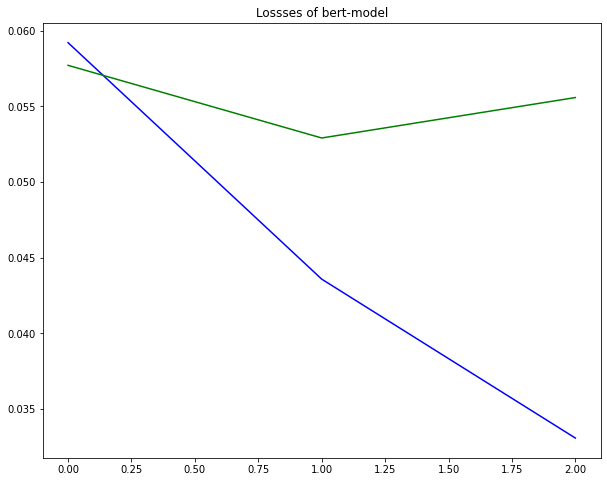

In [21]:
plt.figure(figsize = (10, 8))
plt.plot(train_loss_list, color = 'b')
plt.plot(val_loss_list, color = 'g')
plt.title('Lossses of bert-model')
plt.show()

In [22]:
next(test_loader.__iter__())


(tensor([[  101,  2013, 14645,  1996,  2516,  2003,  2986,  2004,  2009,  2003,
            100,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0],
         [  101,  4216,   100, 13772,  2006,   100,  1517,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,  

In [24]:
text = preprocessing("yo bitch ja rule is more succesful then you ll ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time")
print(text)

yo bitch ja rule is more succesful then you ll ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time


In [30]:
bert.eval()
tokens = tokenize(text)
indexed = [tokenizer.cls_token_id] + tokenizer.convert_tokens_to_ids(tokens) + [tokenizer.sep_token_id]
tensor = torch.LongTensor(indexed).to(device)
tensor = tensor.unsqueeze(0)
# print(tensor)
prediction = torch.sigmoid(bert(tensor)[1])
print(prediction)

tensor([[0.7306, 0.5843, 0.7283, 0.5112, 0.7259, 0.6023]], device='cuda:0',
       grad_fn=<SigmoidBackward>)


# The prediction is not very good